# Time Series Analysis

1. Read BARPA and ERA
2. Select locations for time series
3. plot summary time series
    - FFDI, DWI, FFDI_F
5. look for trends


In [1]:
from glob import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import importlib,warnings


## Put us in the right repo for local relative pathing
import os
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric/"
os.chdir(__repo__)
import plotting, fio


In [2]:
from dask.distributed import Client
client = Client()
#display(client.proxy)
print(client.dashboard_link)

/proxy/8787/status


## GCMs
- evaluation/historical only
    - "ECMWF-ERA5",
    - "MPI-M-MPI-ESM1-2-HR", 
- with ssp projections:
    - "CMCC-CMCC-ESM2", # Just ssp370, and hisorical
    - "CSIRO-ACCESS-ESM1-5", # both ssp370,ssp126, others?
- not yet looked at 
    - "CSIRO-ARCCSS-ACCESS-CM2",
    - "EC-Earth-Consortium-EC-Earth3",
    - "NCAR-CESM2","CSIRO-ACCESS-ESM1-5",
    - "NCC-NorESM2-MM",

## experiments

- "evaluation": 1979-2020
- "historical": 1960-2014
- "ssp126": 2015-2100
- "ssp370": 2015-2100

# 1 Read Data

- Time series: N_series = N_models x N_metrics x N_locations
    - Models: ERA5, several BARPA instances,
    - Metrics: FFDI, FFDI_F, and DWI_V
    - Locations: melb, adelaide, sydney, darwin
        - Darwin has big mismatch between ERA5 and BARPA
            - could be due to grid size (ERA5 is .25, BARPa is .15) giving more ocean or inland area
            - need to add driving metrics to timeseries
    
  

In [4]:
importlib.reload(fio)

## Get index matching location
latlons=fio.TIMESERIES_LOCATIONS


## Check Resolution
# rename lon,lat to match BARPA
ds_ERA5 = fio.ERA5_read_dailymaximums().rename({'longitude':'lon','latitude':'lat'})
ds_cmcc = fio.BARPA_read_intermediate_years("*",experiment='ssp370')


for ds,name in zip([ds_ERA5, ds_cmcc],['era','barpa']):
    print("=======  %s ========"%name)
    
    for (place,deets) in latlons.items():
        lat,lon = deets['latlon']
        abslat = np.abs(ds.lat-lat)
        abslon = np.abs(ds.lon-lon)
        c = np.maximum(abslon, abslat)
        ([xloc], [yloc]) = np.where(c == np.min(c))
    
        print(place,lat,lon)
        print("    ilat, ilon: %d, %d"%(yloc,xloc))
        print("    %s lat,lon:"%name, ds.lat.values[yloc],ds.lon.values[xloc])
    


print("=============== resolution check ============")
print("ERA5: ",ds_ERA5.dims,)
print("    DX:", ds_ERA5.lon.values[1]-ds_ERA5.lon.values[0])
print("    DY:", ds_ERA5.lat.values[1]-ds_ERA5.lat.values[0])
print("BARPA: ", ds_cmcc.dims,) 
print("    DX: %.4f"%(ds_cmcc.lon.values[1]-ds_cmcc.lon.values[0]))
print("    DY: %.4f"%(ds_cmcc.lat.values[1]-ds_cmcc.lat.values[0]))

    

/g/data/en0/jwg574/repos/extra_pip_libs/lib/python3.9/site-packages/ecmwflibs/__init__.py:83: UserWarning: No module named 'ecmwflibs._ecmwflibs'
  warnings.warn(str(e))


INFO: Reading 86 BARPA dailymax files matching year *
=======  era ========
Melb -37.6722 144.8503
    ilat, ilon: 115, 135
    era lat,lon: -37.75 144.75
Adel -34.9063 138.8397
    ilat, ilon: 104, 111
    era lat,lon: -35.0 138.75
Sydn -33.8 150.7
    ilat, ilon: 99, 159
    era lat,lon: -33.75 150.75
Darw -12.464 130.85
    ilat, ilon: 14, 79
    era lat,lon: -12.5 130.75
Dar2 -12.71 131.1
    ilat, ilon: 15, 80
    era lat,lon: -12.75 131.0
=======  barpa ========
Melb -37.6722 144.8503
    ilat, ilon: 103, 368
    barpa lat,lon: -37.662 144.89149
Adel -34.9063 138.8397
    ilat, ilon: 121, 329
    barpa lat,lon: -34.881 138.866
Sydn -33.8 150.7
    ilat, ilon: 128, 406
    barpa lat,lon: -33.7995 150.7625
Darw -12.464 130.85
    ilat, ilon: 266, 277
    barpa lat,lon: -12.4785 130.832
Dar2 -12.71 131.1
    ilat, ilon: 265, 279
    barpa lat,lon: -12.633 131.14099
=============== resolution check ============
ERA5:  Frozen({'lon': 177, 'lat': 157, 'time': 24472})
    DX: 0.25
    D

In [3]:
%%time
#importlib.reload(fio)
## takes ? minutes for new creation
## Uses ~ 4 GB RAM
ts_melb = fio.get_time_series("Melb",force_renew=True,verbose=True)

/g/data/en0/jwg574/repos/extra_pip_libs/lib/python3.9/site-packages/ecmwflibs/__init__.py:83: UserWarning: No module named 'ecmwflibs._ecmwflibs'
  warnings.warn(str(e))


INFO: Reading 86 BARPA dailymax files matching year *
INFO: Reading 55 BARPA dailymax files matching year *
INFO: Reading 86 BARPA dailymax files matching year *
INFO: Reading 86 BARPA dailymax files matching year *
INFO: Loading  Melb_FFDI_CMCC_hist
INFO: dropping 0 null values from Melb_FFDI_CMCC_hist
INFO: Loading  Melb_FFDI_CMCC_370
INFO: dropping 0 null values from Melb_FFDI_CMCC_370
INFO: Loading  Melb_FFDI_CSIRO_ESM_370
INFO: dropping 2 null values from Melb_FFDI_CSIRO_ESM_370
INFO: Loading  Melb_FFDI_CSIRO_ESM_126
INFO: dropping 4 null values from Melb_FFDI_CSIRO_ESM_126
Loading ERA_5
INFO: Loading  Melb_DWI_V_CMCC_hist
INFO: dropping 0 null values from Melb_DWI_V_CMCC_hist
INFO: Loading  Melb_DWI_V_CMCC_370
INFO: dropping 0 null values from Melb_DWI_V_CMCC_370
INFO: Loading  Melb_DWI_V_CSIRO_ESM_370
INFO: dropping 2 null values from Melb_DWI_V_CSIRO_ESM_370
INFO: Loading  Melb_DWI_V_CSIRO_ESM_126
INFO: dropping 4 null values from Melb_DWI_V_CSIRO_ESM_126
Loading ERA_5
INFO: Lo

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py", line 1446, in _construct_dataarray
    variable = self._variables[name]
KeyError: 'FFDI_F'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/IPython/core/magics/execution.py", line 1340, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 4, in <module>
  File "/g/data/en0/jwg574/repos/simple_fire_metric/fio.py", line 429, in get_time_series
    TSE=ds_ERA5[metric][:,y_era,x_era].load()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dataset.py", line 1544, in __getitem__
    return self._construct_dataarray(key)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/core/dat

In [4]:
ts_melb.keys()

dict_keys(['Melb_FFDI_CMCC_hist', 'Melb_FFDI_CMCC_370', 'Melb_FFDI_CSIRO_ESM_370', 'Melb_FFDI_CSIRO_ESM_126', 'Melb_FFDI_ERA5', 'Melb_DWI_V_CMCC_hist', 'Melb_DWI_V_CMCC_370', 'Melb_DWI_V_CSIRO_ESM_370', 'Melb_DWI_V_CSIRO_ESM_126', 'Melb_DWI_V_ERA5'])

In [6]:
ts_adel = fio.get_time_series('Adel',force_renew=True)

INFO: Reading 86 BARPA dailymax files matching year *
INFO: Reading 55 BARPA dailymax files matching year *
INFO: Reading 86 BARPA dailymax files matching year *
INFO: Reading 86 BARPA dailymax files matching year *
INFO: Saving data/timeseries_Adel.pickle


# 2. Show some time series for Locations

1. Yearly Maximum timeseries
2. Yearly 90th pctile
3. Mean seasonality (pre 2020, 2020-2080, post 2080)
4. Monthly time series (time series just for Jan, Feb, ..., independently) to see change in seasonality


In [11]:
#ts_places
from pylab import rcParams
import warnings # want to ignore calendar conversion warnings
from datetime import datetime

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


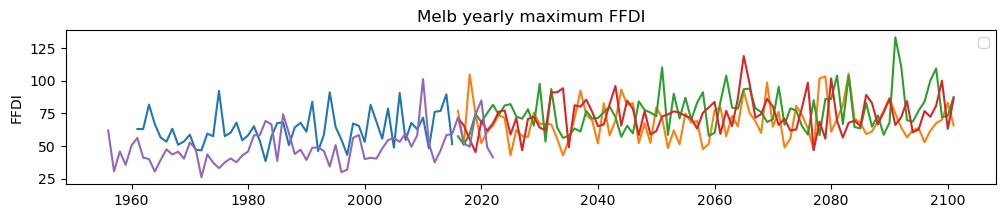

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


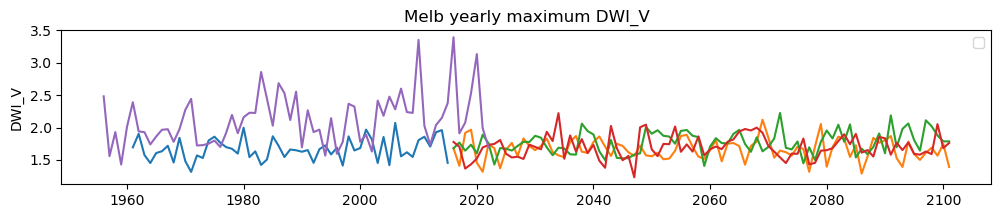

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


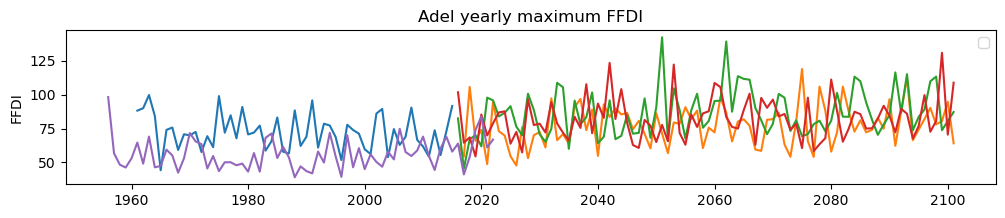

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


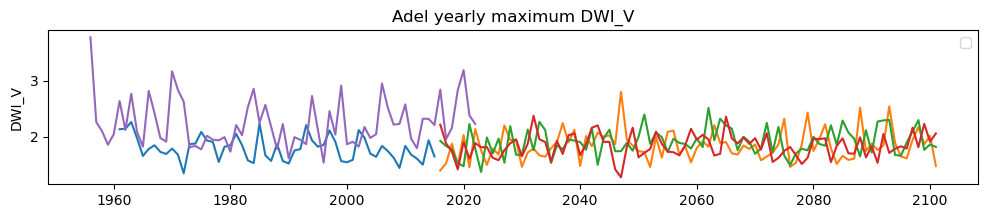

In [27]:
rcParams['figure.figsize'] = 12, 2
## Show each place on one plot

ts_places = [ts_melb,ts_adel]
for ts in ts_places:
    for metric in ['FFDI','DWI_V']:
        
        for name,da in ts.items():
            # only one metric at a time
            if not (metric in name):
                continue
            yearly_max = da.resample('Y').quantile(1.0)
            x = yearly_max.index
            y = yearly_max.values
            #print(yearly_max)
            plt.plot_date(x,y,'-',label=name[slice(5+len(metric),-1)])
        placename=name[:4]
                
        #assert False,"stop here"
        #plt.gca().set_xlim([datetime(1955, 1, 1), datetime(2102, 1, 1)])
        plt.title(placename+' yearly maximum '+metric)
        plt.ylabel(metric)
        plt.legend()
        plt.show()
    
    #plt.title("FFDI")
    #plt.xlim([np.datetime64('1960-01-01'),np.datetime64('2101-01-01')])

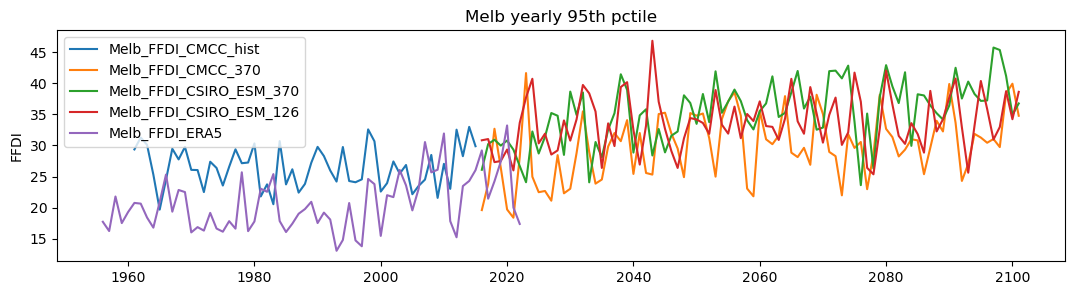

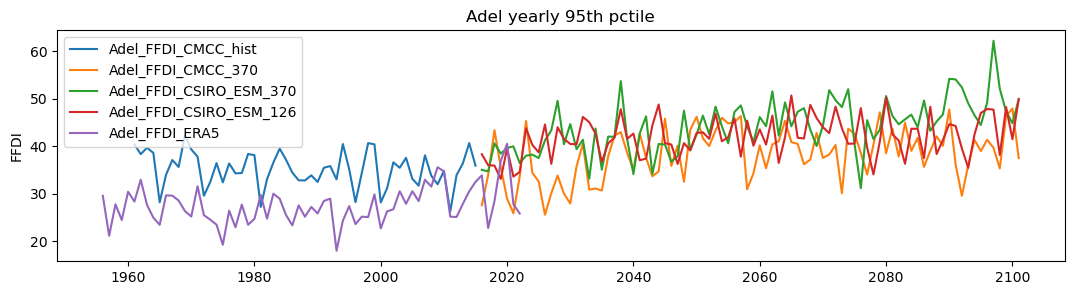

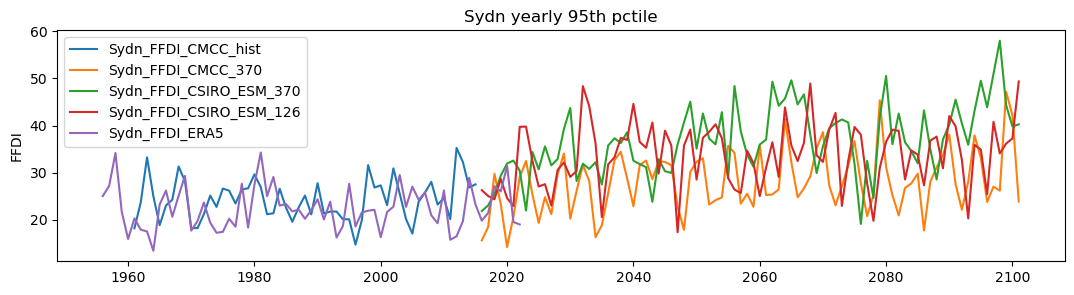

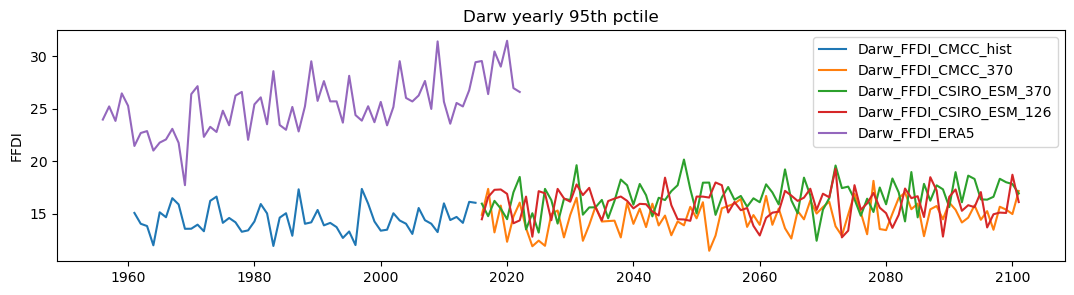

In [93]:
## Show each place on one plot
for placename in latlons.keys():
    for varname,da in ts_places.items():
        if varname[:4] == placename:
            yearly_max = da.resample('Y').quantile(.95)
            x = yearly_max.index
            y = yearly_max.values
            
            plt.plot_date(x,y,'-',label=varname)
            #assert False,"stop here"
    plt.title(placename+' yearly 95th pctile')
    plt.ylabel("FFDI")
    plt.legend()
    plt.show()

#plt.title("FFDI")
#plt.xlim([np.datetime64('1960-01-01'),np.datetime64('2101-01-01')])

## Decomposition of season

In [94]:
import statsmodels.api as sm
import pandas as pd

Melb_FFDI_CMCC_hist has nulls?  False


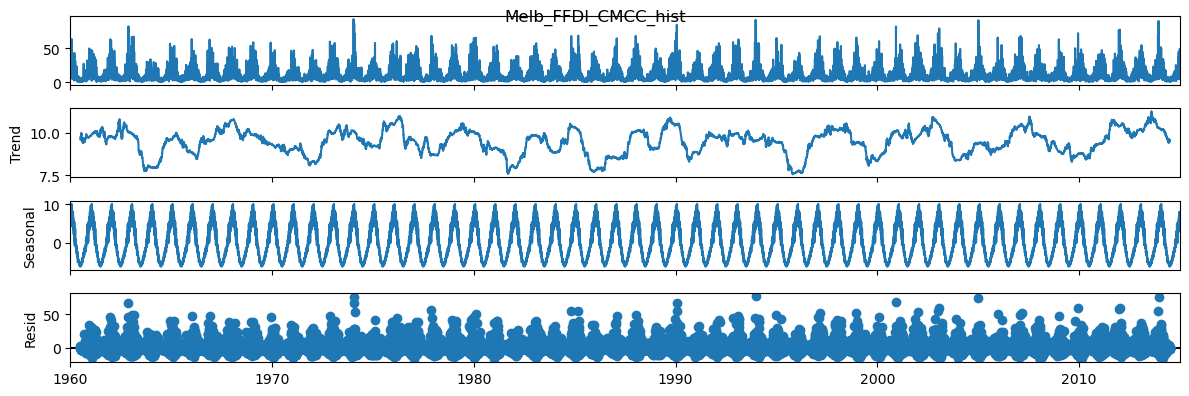

Melb_FFDI_CMCC_370 has nulls?  False


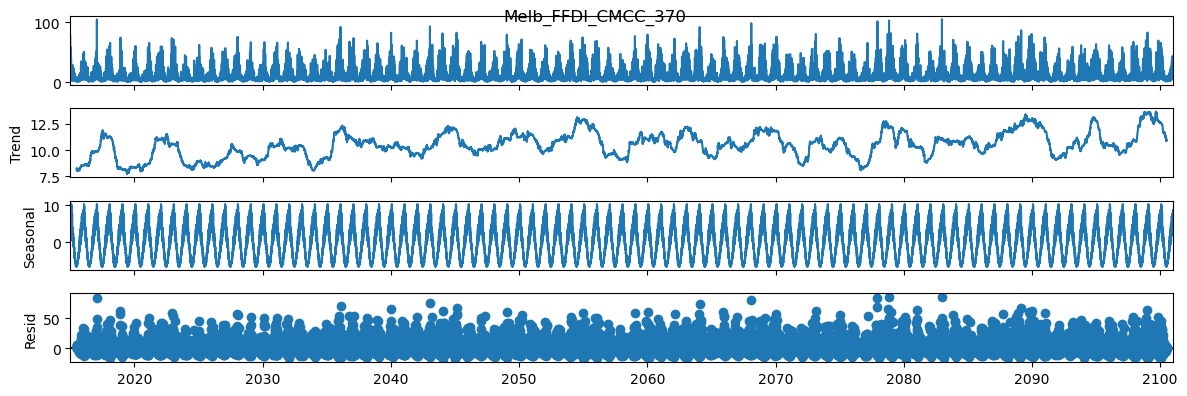

Melb_FFDI_CSIRO_ESM_370 has nulls?  True


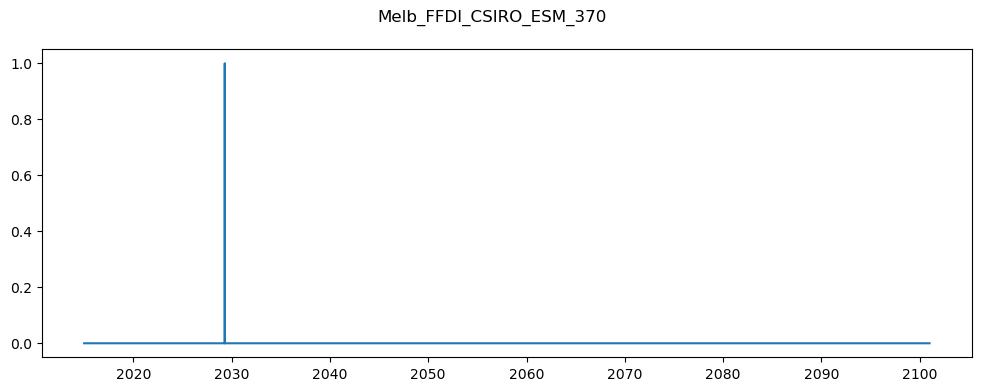

Melb_FFDI_CSIRO_ESM_126 has nulls?  True


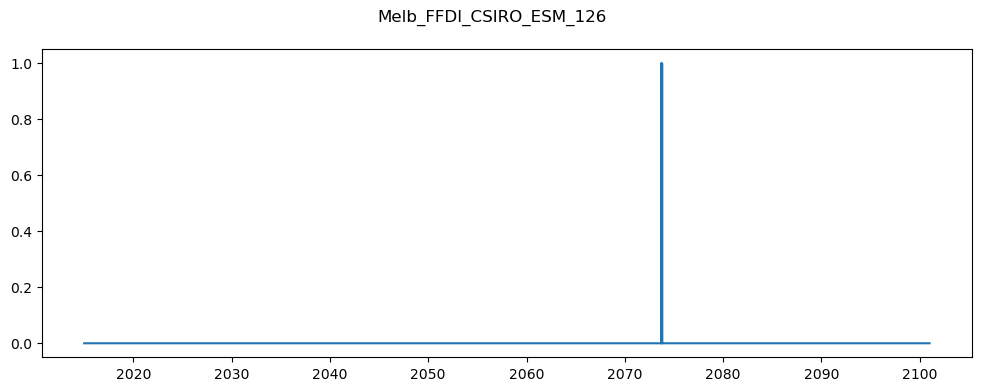

Melb_FFDI_ERA5 has nulls?  False


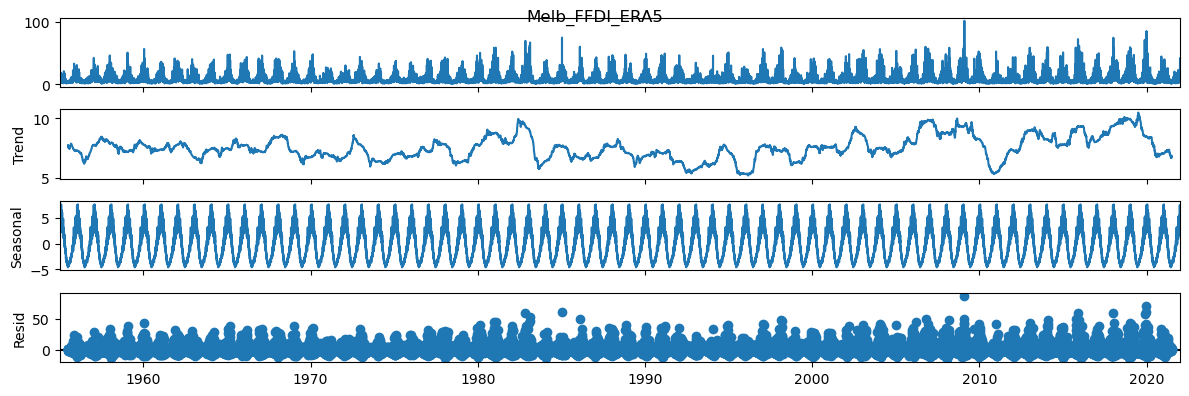

Adel_FFDI_CMCC_hist has nulls?  False


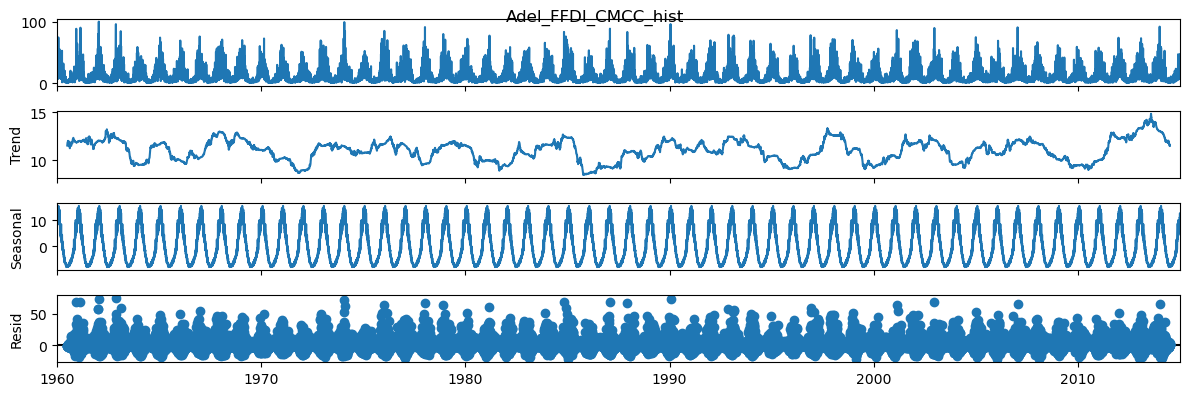

Adel_FFDI_CMCC_370 has nulls?  False


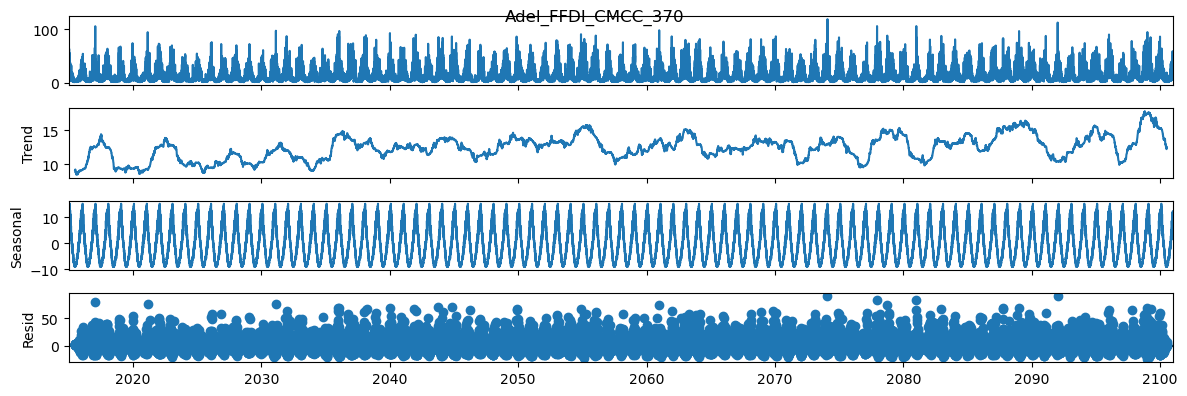

Adel_FFDI_CSIRO_ESM_370 has nulls?  True


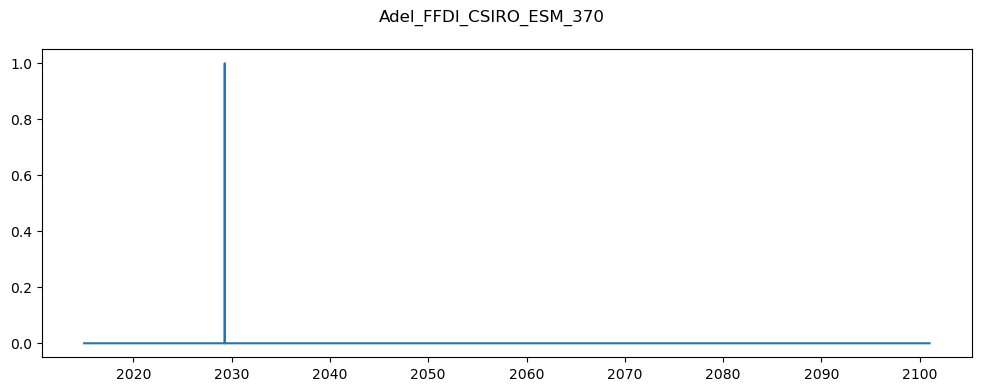

Adel_FFDI_CSIRO_ESM_126 has nulls?  True


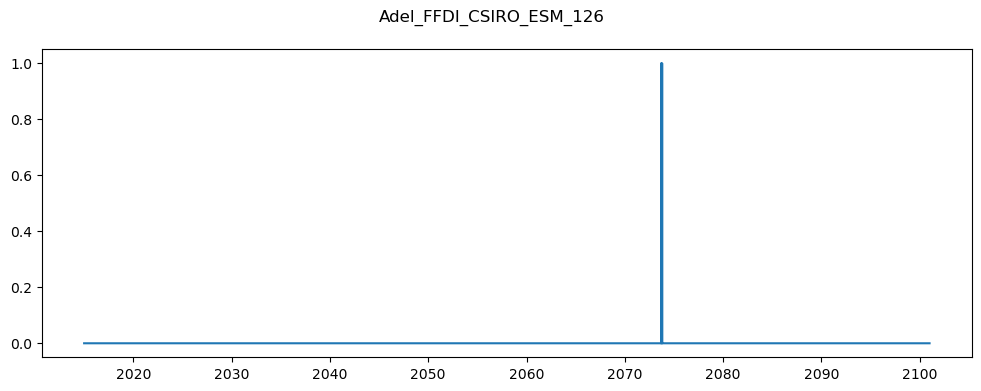

Adel_FFDI_ERA5 has nulls?  False


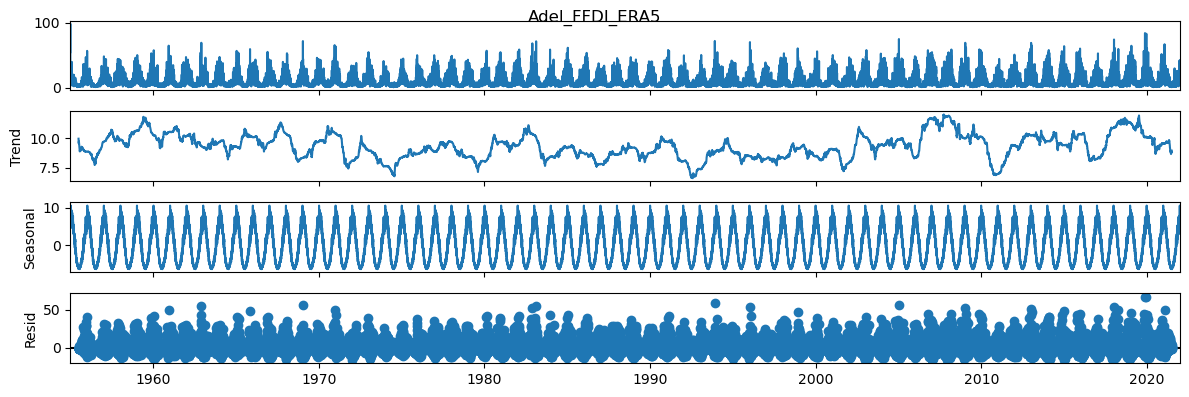

Sydn_FFDI_CMCC_hist has nulls?  False


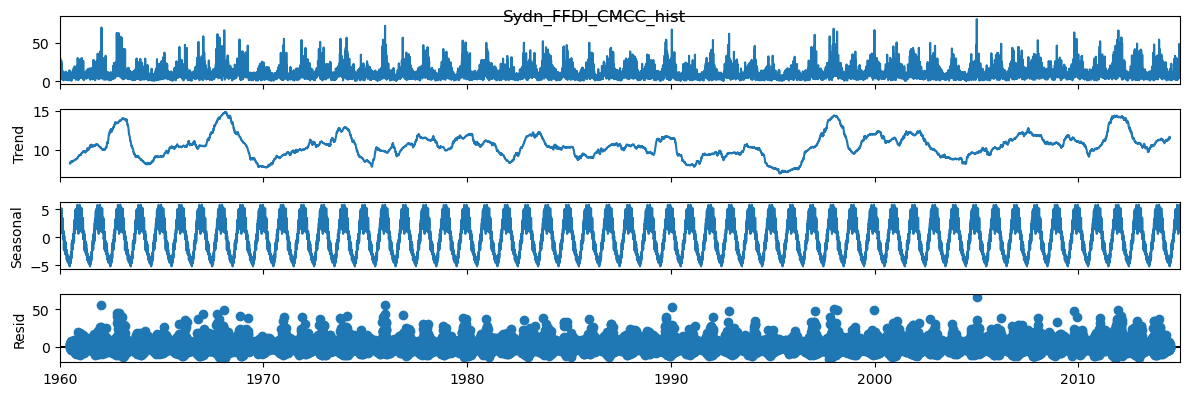

Sydn_FFDI_CMCC_370 has nulls?  False


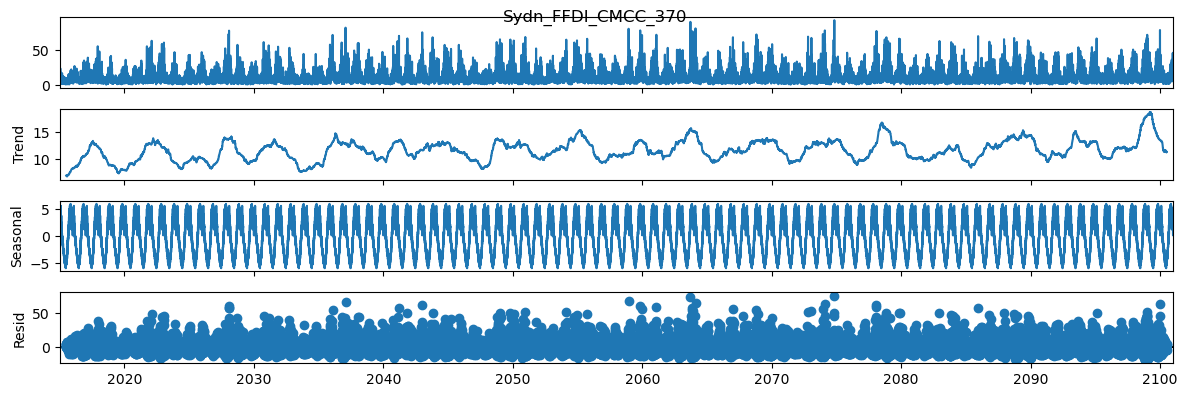

Sydn_FFDI_CSIRO_ESM_370 has nulls?  True


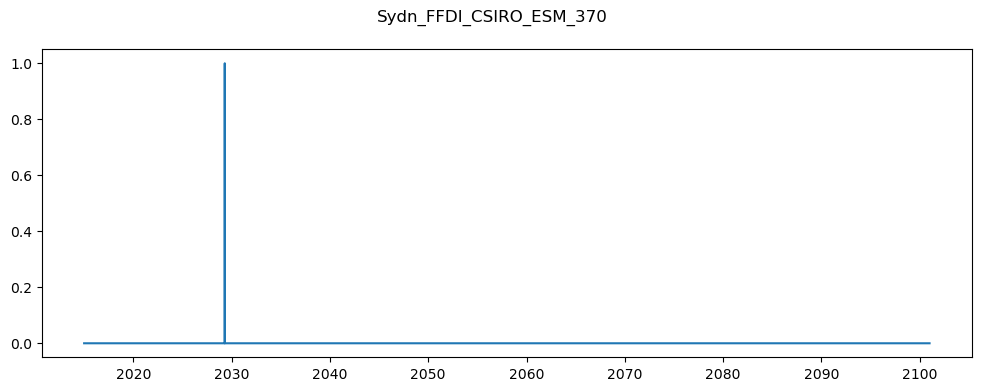

Sydn_FFDI_CSIRO_ESM_126 has nulls?  True


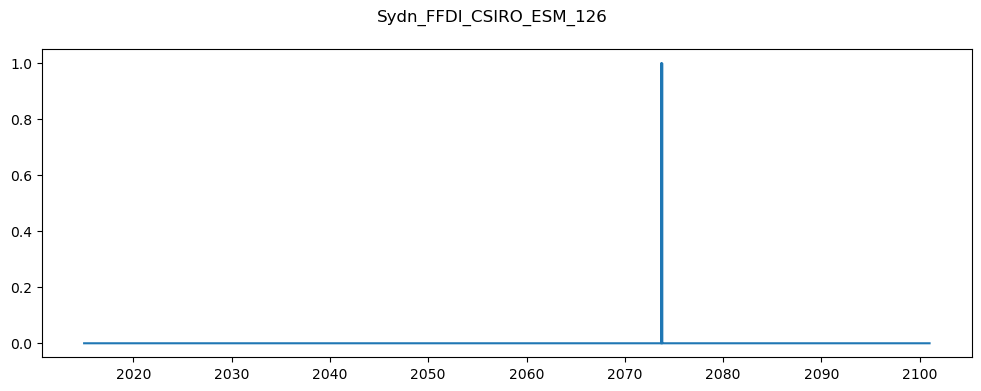

Sydn_FFDI_ERA5 has nulls?  False


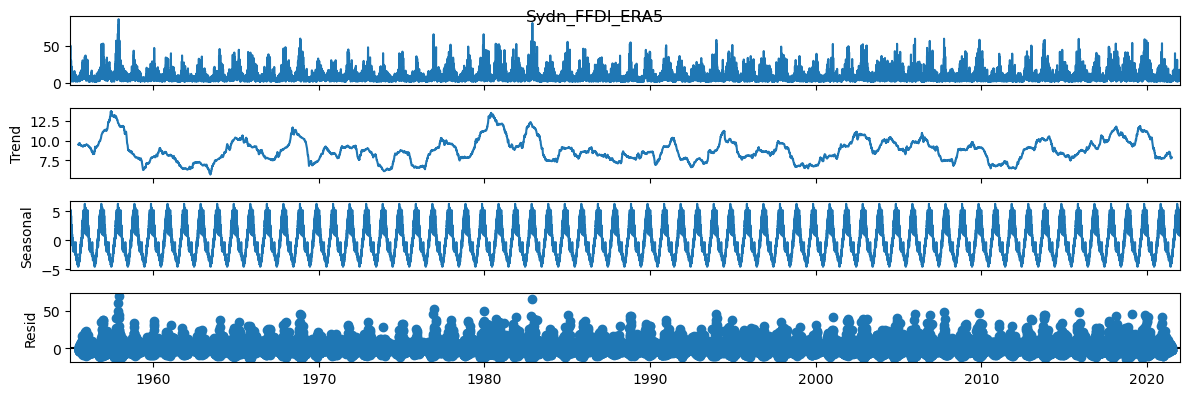

Darw_FFDI_CMCC_hist has nulls?  False


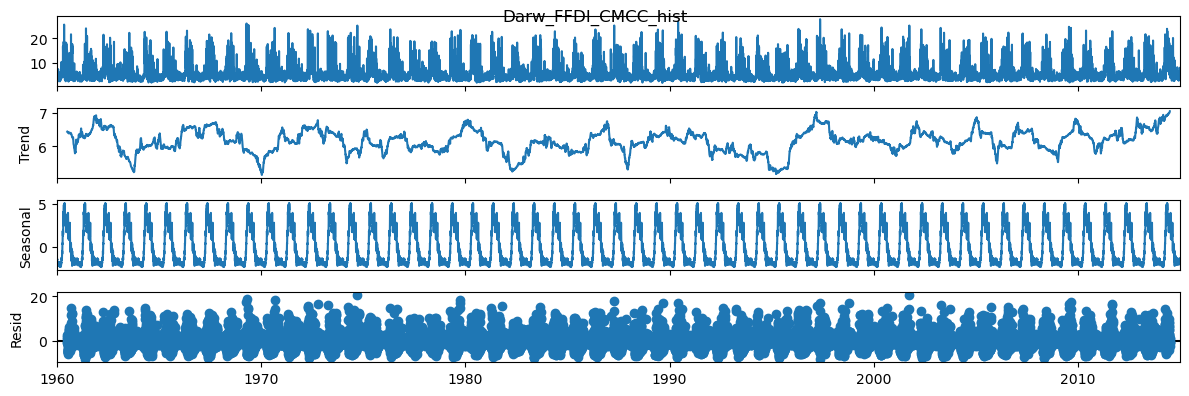

Darw_FFDI_CMCC_370 has nulls?  False


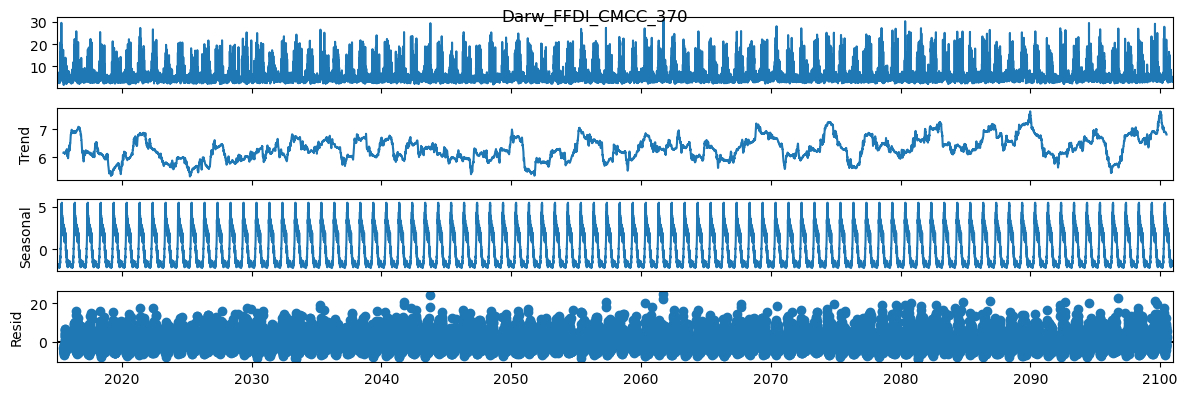

Darw_FFDI_CSIRO_ESM_370 has nulls?  True


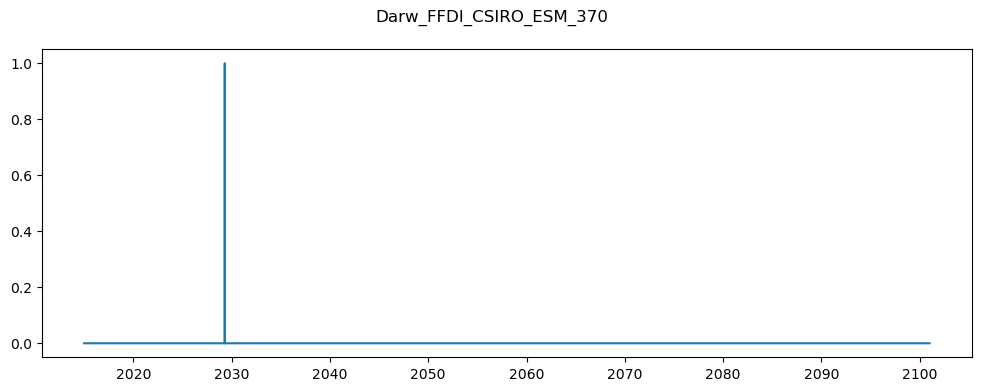

Darw_FFDI_CSIRO_ESM_126 has nulls?  True


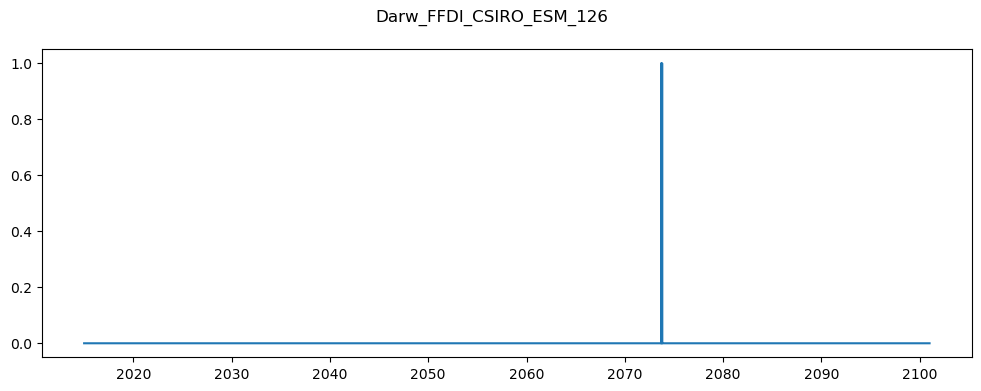

Darw_FFDI_ERA5 has nulls?  False


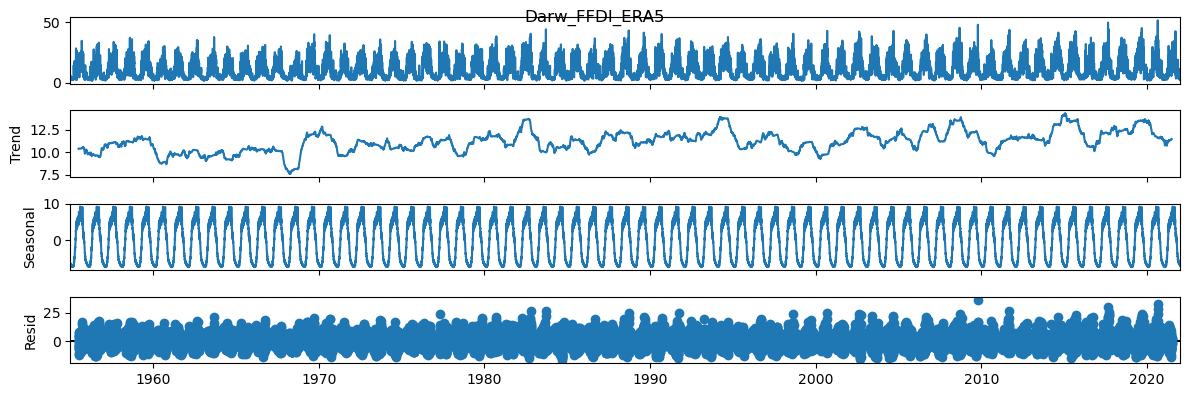

In [97]:
## Show each place on one plot
rcParams['figure.figsize'] = 12, 4
for varname,da in ts_places.items():
    da1=da.copy()
    if da.isnull().values.any():
        print(varname, "has %d nulls"%da.isnull().sum())
        da1=da
    else:
        decomposition = sm.tsa.seasonal_decompose(da, model='additive',period=365)
        fig = decomposition.plot()
    plt.suptitle(varname)
    plt.show()

    #assert False,"stop here"

    #plt.title(placename+' yearly 95th pctile')
    #plt.ylabel("FFDI")
    #plt.legend()
    #plt.show()
